In [196]:
import warnings, math, itertools, json, logging, os
from hashlib import md5

import numpy as np
import pandas as pd

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import shap
shap.initjs()

%load_ext autoreload
%autoreload 1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class Notebook:
    PARALLEL_CROSS_VALIDATION = False


In [419]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    fbeta_score,
    make_scorer,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

f2_score = make_scorer(fbeta_score, beta=2)

METRICS = {
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": "roc_auc",
    "F1 Score": "f1",
    "F2 Score": f2_score,
}


def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "F2 Score": fbeta_score(y_true, y_pred, beta=2),
    }

def evaluate(model, X, y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    display(pd.DataFrame({
        **get_metrics(y, y_pred),
        'AUC': roc_auc_score(y, y_pred_proba[:,1])
    }, index=['Model']))

    fig, ax=plt.subplots(1,1, figsize=(5,5))
    ax.grid(False)
    ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax)


In [5]:
from sklearn.model_selection import train_test_split


def train_test_split_notna(*frames, test_size=0.25, random_state=42):
    """ Split DataFrames or Series into random train and test subsets, such that the test subset contains no NaN values.
    """
    X = frames[0]
    mask = ~X.reset_index(drop=True).isna().any(axis=1)
    sub_size = test_size * X.shape[0] / mask.sum()

    rem_idx, test_idx = train_test_split(
        mask[mask].index, test_size=sub_size, random_state=random_state
    )
    rem_idx = np.concatenate([rem_idx, mask[~mask].index])

    return tuple(__ for _ in frames for __ in (_.iloc[rem_idx], _.iloc[test_idx]))



In [6]:
from cross_validation import cross_validate_parallel, cross_validate_linear
from sklearn.model_selection import cross_validate
%aimport cross_validation

def spotCheckCV(models, X, y, cv=3, parallel=Notebook.PARALLEL_CROSS_VALIDATION):
    crossval_function = cross_validate_parallel if parallel else cross_validate_linear
    models = {'Model':models} if type(models) != dict else models

    r = crossval_function(models, X, y, scoring=METRICS, cv=cv) 

    return pd.concat([pd.DataFrame(r[_]).assign(model=_) for _ in r.keys()]).groupby('model').mean()  

def spotCheckDatasets(models, datasets, cv=3):
    pd.concat([
        pd.DataFrame.from_dict(cross_validate(model, X, y, cv=cv, scoring=METRICS, n_jobs=-1)).assign(dataset=dataname, model=modelname)
        for modelname, model in models.items() for dataname, (X, y) in datasets.items()
    ]).groupby(['dataset', 'model']).mean()

In [312]:
from dataset import SCIData, SCICols
%aimport dataset
#SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_readmission().omit_vbg()
sci = SCIData.load('data/sci_processed_2.h5').fix_readmissionband().derive_critical_event(within=2)

## LR with NEWS only

Dataset: NEWS components (raw) only, rows with NaN anywhere in this subset are dropped.

In [78]:
scii = sci.mandate(SCICols.news_data_raw)
X_train, X_test, y_train, y_test = train_test_split(
    *scii.xy(x=SCICols.news_data_raw, dtype=float, outcome="CriticalEvent")
)
print(f"Dataset (variant) size: {scii.shape[0]}")



Dataset (variant) size: 124162


Testing logistic regression (L2 penalty, by default), with and without class balancing (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

Both (barely) outperform the baseline NEWS model, which had AUC `0.807` for this outcome. Balanced variant significantly improves recall (thus minimising false-negatives) but the final value remains low.

In [17]:
from sklearn.linear_model import LogisticRegression

models = {
    "LR": LogisticRegression(random_state=42),
    "LR_Balanced": LogisticRegression(class_weight="balanced", random_state=42),
}
spotCheckCV(models, X_train, y_train)


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
LR,0.786281,0.036451,0.984193,0.598473,0.054071,0.820740,0.099123,0.066085
LR_Balanced,0.702964,0.046860,0.863801,0.075486,0.663540,0.818887,0.135542,0.259353


The baseline model's pre-defined risk ratio (NEWS score $\geq 7$) yields its own precision and recall "ratio". I.e., it balances false-positives and negatives in a certain way. We can emulate this tradeoff by adjusting the class threshold in the regression model. 

In [80]:
def get_news_target_ratio(X, y):
    y_pred = X.c_NEWS_score >= 7
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    print(f"NEWS Precision={p:.5f}, Recall={r:.5f}")
    return p / r


# Get the "target" ratio of precision/recall that the NEWS threshold produces
target_ratio = get_news_target_ratio(
    *sci.mandate(SCICols.news_data_raw).xy(outcome="CriticalEvent")
)

# Train the LR model
log = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000).fit(
    X_train, y_train
)

# Get candidate thresholds from the model, and find the one that gives the ratio closest to the target
precision, recall, thresholds = precision_recall_curve(
    y_train, log.predict_proba(X_train)[:, 1]
)
closest = thresholds[
    np.abs(
        np.divide(precision, recall, out=np.ones_like(recall), where=recall != 0)
        - target_ratio
    ).argmin()
]



NEWS Precision=0.22975, Recall=0.26733


On the test set, this gives much improved F2, while the AUC remains consistent (slightly better than baseline model).

In [84]:
# Create predictions on the test set, using this new threshold
y_pred_proba = log.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba > closest, 1, 0)

# Produce scores
display(pd.DataFrame(get_metrics(y_test, y_pred), index=["LR_Calibrated"]))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.5f}")


,Accuracy,Precision,Recall,F1 Score,F2 Score
LR_Calibrated,0.972842,0.220033,0.266932,0.241224,0.256018


AUC: 0.82744


## XGB with all except A&E

Dataset: All non-redudnant, except A&E
 - All NEWS parameters are mandated, raw NEWS used
 - Blood tests are imputed
 - Diagnoses are HSMR grouped and one-hot encoded

In [12]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .impute_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
)
X_train, X_test, y_train, y_test = train_test_split_notna(
    *scii.xy(outcome="CriticalEvent")
)
print(f"Dataset (variant) size: {scii.shape[0]}")



Dataset (variant) size: 96859


In [72]:
from xgboost import XGBClassifier

spotCheckCV(
    {
        "XGB_Unweighted": XGBClassifier(
            tree_method="approx", enable_categorical=True, scale_pos_weight=1
        ),
        "XBG_Weighted": XGBClassifier(
            tree_method="approx",
            enable_categorical=True,
            scale_pos_weight=round(y_train.shape[0] / y_train.sum()),
        ),  # Weight=58
    },
    X_train,
    y_train,
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XBG_Weighted,16.104220,0.466719,0.974437,0.325599,0.448887,0.881964,0.377048,0.416953
XGB_Unweighted,15.998302,0.463435,0.982834,0.504456,0.202064,0.922200,0.288315,0.229514


In [40]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC


def test_xgb_variants(scii):
    X, y = scii.xy(outcome="CriticalEvent", ordinal_encoding=False, dropna=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25
    )

    print(f"Dataset (variant) size: {X_train.shape[0]+X_test.shape[0]}")

    categorical_cols_idx, _  = X.describe_categories()

    display(
        spotCheckCV(
            {
                "XGB": XGBClassifier(
                    tree_method="approx", enable_categorical=True, scale_pos_weight=1
                ),
                "XGB_Balanced": XGBClassifier(
                    tree_method="approx",
                    enable_categorical=True,
                    scale_pos_weight=round(y_train.shape[0] / y_train.sum()),
                ),  # Weight=58
                "XGB_Under": ImbPipeline(
                    steps=[
                        ("under", RandomUnderSampler(sampling_strategy=0.1)),
                        (
                            "clf",
                            XGBClassifier(
                                tree_method="approx",
                                enable_categorical=True,
                                scale_pos_weight=1,
                            ),
                        ),
                    ]
                ),
                "XGB_SMOTE": ImbPipeline(
                    steps=[
                        ("smote", SMOTENC(categorical_features=categorical_cols_idx)),
                        (
                            "clf",
                            XGBClassifier(
                                tree_method="approx",
                                enable_categorical=True,
                                scale_pos_weight=1,
                            ),
                        ),
                    ]
                ),
                "XGB_UnderOver": ImbPipeline(
                    steps=[
                        (
                            "oversampling",
                            SMOTENC(
                                categorical_features=categorical_cols_idx,
                                sampling_strategy=0.1,
                            ),
                        ),
                        ("undersampling", RandomUnderSampler(sampling_strategy=0.5)),
                        (
                            "clf",
                            XGBClassifier(
                                tree_method="approx",
                                enable_categorical=True,
                                scale_pos_weight=1,
                            ),
                        ),
                    ]
                ),
            },
            X_train,
            y_train,
        )
    )



With one-hot encoded diagnoses:

In [17]:
test_xgb_variants(
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .impute_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
)


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,3.767634,0.114553,0.981746,0.575909,0.219132,0.925099,0.315181,0.249391
XGB_Balanced,3.536348,0.114554,0.980541,0.494180,0.316556,0.908459,0.385224,0.340777
XGB_SMOTE,13.255368,0.112172,0.980713,0.506934,0.275232,0.916692,0.355915,0.302584
XGB_Under,0.952903,0.124968,0.976293,0.419023,0.538559,0.933087,0.469889,0.508349
XGB_UnderOver,3.277489,0.109348,0.973538,0.383070,0.591656,0.927745,0.464944,0.533454


Without one-hot encoded diagnoses:

In [42]:
test_xgb_variants(
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .impute_blood()
    .raw_news()
    .impute_news()
    .augment_hsmr()
)


Dataset (variant) size: 170833


c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\imblearn\pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "c:\Users\stybl\miniconda3\envs\py39\lib\site-packages\imblearn\pipeline.py", line 236, in _fit
    X, y, fitted_transformer = 

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,21.026801,0.846234,0.983594,0.511167,0.186233,0.920800,0.272537,0.213217
XGB_Balanced,20.919317,0.791288,0.955410,0.194674,0.539840,0.883251,0.286152,0.398514
XGB_SMOTE,0.260358,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
XGB_Under,4.520772,0.873516,0.974938,0.332510,0.507779,0.923093,0.401692,0.459188
XGB_UnderOver,0.275974,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


With imputed NEWS:

In [33]:
test_xgb_variants(
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand"], axis=1)
    .omit_ae()
    .impute_blood()
    .raw_news()
    .impute_news()
    .augment_hsmr()
    .encode_ccs_onehot()
)


,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
XGB,21.934185,0.843507,0.984277,0.533590,0.188557,0.921929,0.278614,0.216554
XGB_Balanced,22.190099,0.789853,0.953273,0.183599,0.551244,0.887881,0.275405,0.393516
XGB_SMOTE,68.275238,0.709234,0.984349,0.538782,0.193035,0.918643,0.284089,0.221413
XGB_Under,4.611659,0.799746,0.976704,0.349870,0.519900,0.923083,0.418243,0.473823
XGB_UnderOver,16.162933,0.805609,0.976007,0.333761,0.490050,0.923026,0.396767,0.447794


The success of undersampling indicates that smaller volume of training data may be ok. Restricting the dataset to only rows with no missing values (only 46300/173800) maintains testing set performance.

When "AdmissionSpeciality" is present, it receives the highest feature importance by far. However, including it may not be appropriate. Removing it doesn't impact performance much at all.

In [92]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
)
X_train, X_test, y_train, y_test = train_test_split(
    *scii.xy(outcome="CriticalEvent", dropna=False)
)
model = ImbPipeline(
    steps=[
        ("under", RandomUnderSampler(sampling_strategy=0.1)),
        (
            "clf",
            XGBClassifier(
                tree_method="approx",
                enable_categorical=True,
                scale_pos_weight=1,
                importance_type='gain'
            ),
        ),
    ]
).fit(X_train, y_train)

evaluate(model, X_test, y_test)

{'Accuracy': 0.9747732181425486,
 'Precision': 0.32170542635658916,
 'Recall': 0.415,
 'F1 Score': 0.36244541484716164,
 'F2 Score': 0.3922495274102079,
 'AUC': 0.9354189010989009}

<AxesSubplot:>

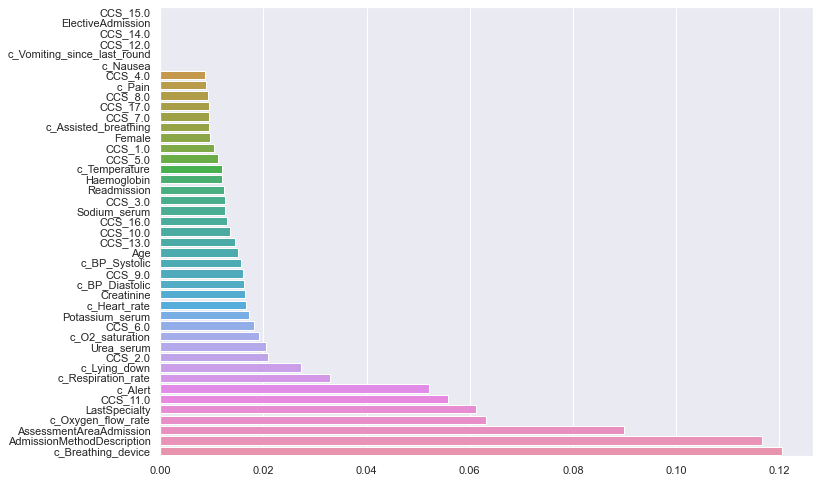

In [93]:
sorted_idx = model['clf'].feature_importances_.argsort()
sns.barplot(x=model['clf'].feature_importances_[sorted_idx], y=X_train.columns[sorted_idx])


In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": 180,
    "seed": 0,
}


def objective(space):
    clf = XGBClassifier(
        tree_method="approx",
        enable_categorical=True,
        n_estimators=space["n_estimators"],
        max_depth=int(space["max_depth"]),
        gamma=space["gamma"],
        reg_alpha=int(space["reg_alpha"]),
        min_child_weight=int(space["min_child_weight"]),
        colsample_bytree=int(space["colsample_bytree"]),
    )
    r = cross_validate(
        clf, X_train.head(10000), y_train[:10000], cv=5, n_jobs=5, scoring="roc_auc"
    )
    score = r["test_score"].mean()
    print(f"SCORE: {score}")
    return {"loss": -score, "status": STATUS_OK}



In [ ]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials
)



SCORE: 0.5                                             
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                         
SCORE: 0.5                                                          
SCORE: 0.5                                                          
SCORE: 0.5                                                          
SCORE: 0.5                                                          
SCORE: 0.5                                              

## Other boosters (HGBC, LightGBM)

In [114]:
from sklearn.ensemble import HistGradientBoostingClassifier

scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
)

def test_hgbc(scii):
    X, y = scii.xy(outcome="CriticalEvent", ordinal_encoding=False, dropna=False)
    categorical_cols_idx, _ = X.describe_categories()

    X = X.ordinal_encode_categories()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y
    )

    return spotCheckCV(
        HistGradientBoostingClassifier(categorical_features=categorical_cols_idx), X_train, y_train
    )

test_hgbc(scii)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Model,0.848505,0.130514,0.982721,0.457601,0.186261,0.933519,0.263661,0.210968


In [121]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
)

X, y = scii.xy(outcome="CriticalEvent", dropna=False)
categorical_cols_idx, _ = X.describe_categories()

X_train, X_test, y_train, y_test = train_test_split(
    X, y
)


spotCheckCV(LGBMClassifier(), X_train, y_train)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Model,0.564471,0.316422,0.983643,0.523452,0.212435,0.936203,0.30215,0.241061


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

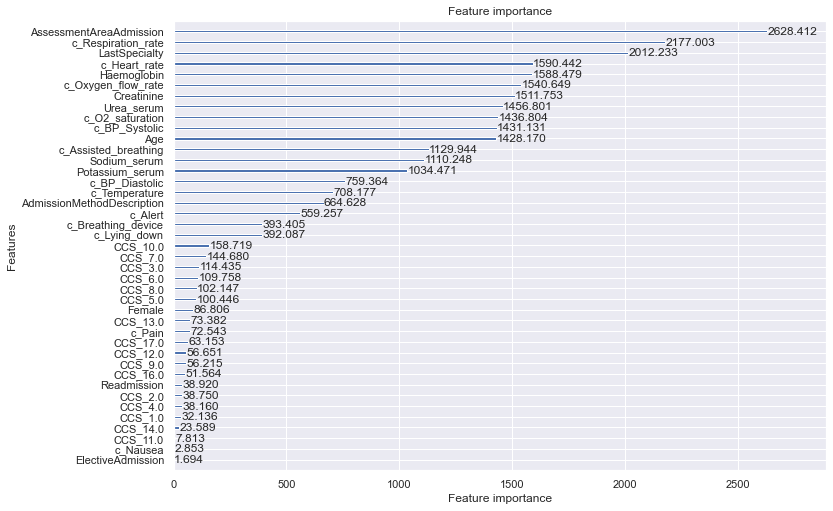

In [123]:
lgb.plot_importance(LGBMClassifier(importance_type='gain').fit(X_train, y_train))


## RF

Using random undersampling at a 1:10 ratio achieves some of the best performance overall.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X, y = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AandEPresentingComplaint"], axis=1)
    .omit_ae()
    .impute_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", ordinal_encoding=True, dropna=True)
)

In [ ]:
spotCheckCV(
    {
        "RF": Pipeline(steps=[("clf", RandomForestClassifier())]),
        "RF_Balanced": Pipeline(
            steps=[("clf", RandomForestClassifier(class_weight="balanced_subsample"))]
        ),
        "RF_Under": ImbPipeline(
            steps=[
                ("under", RandomUnderSampler(sampling_strategy=0.5)),
                ("clf", RandomForestClassifier()),
            ]
        ),
        "RF_UnderLess": ImbPipeline(
            steps=[
                ("under", RandomUnderSampler(sampling_strategy=0.1)),
                ("clf", RandomForestClassifier()),
            ]
        ),
        "RF_SMOTE": ImbPipeline(
            steps=[("smote", SMOTE()), ("clf", RandomForestClassifier())]
        ),
        "RF_UnderOver": ImbPipeline(
            steps=[
                ("oversampling", SMOTE(sampling_strategy=0.1)),
                ("undersampling", RandomUnderSampler(sampling_strategy=0.5)),
                ("clf", RandomForestClassifier()),
            ]
        ),
    },
    X,
    y,
)



,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
RF,12.460412,0.817458,0.983083,0.637468,0.058444,0.915047,0.107025,0.071409
RF_Balanced,11.599754,0.873534,0.982970,0.653470,0.043014,0.915463,0.080580,0.052873
RF_SMOTE,21.181878,0.690089,0.982463,0.475895,0.094157,0.913048,0.156983,0.112096
RF_Under,0.926862,1.426822,0.925649,0.158551,0.759733,0.927977,0.262295,0.431912
RF_UnderLess,2.754398,1.398336,0.977232,0.375877,0.469976,0.927338,0.417592,0.447487
RF_UnderOver,4.027929,1.283501,0.975160,0.341806,0.464277,0.922724,0.393706,0.433204


In [349]:
X, y = (
    sci.omit_redundant()
    .omit_ae()
    .impute_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", ordinal_encoding=True, dropna=True)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

In [351]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

model = ImbPipeline(
            steps=[
                ("under", RandomUnderSampler(sampling_strategy=0.1)),
                ("clf", RandomForestClassifier()),
            ]
        ).fit(X_train, y_train)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC
Model,0.977162,0.40249,0.434978,0.418103,0.428067,0.933237


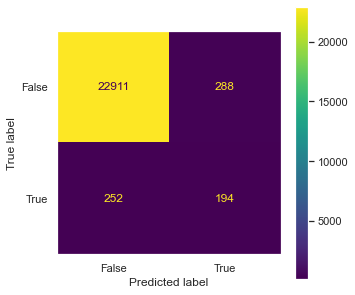

In [412]:
evaluate(model, X_test, y_test)

In [359]:
import shap
explainer = shap.TreeExplainer(model['clf'])
shap_values = explainer.shap_values(X_test) 


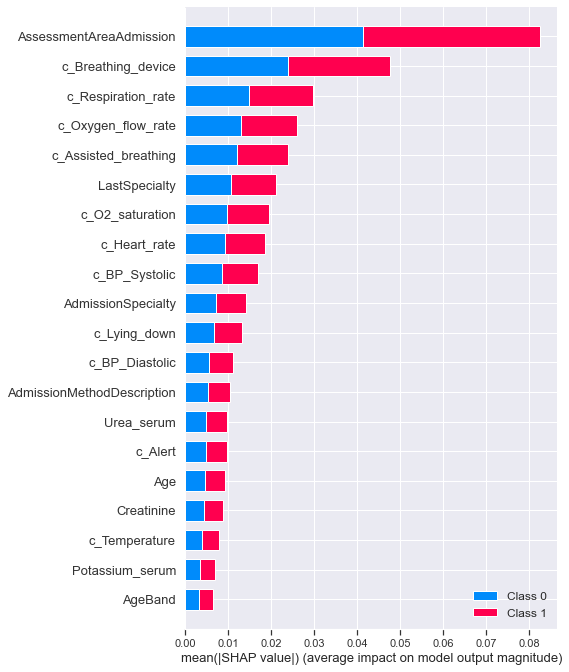

In [360]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [366]:
explainer.expected_value

array([0.9091208, 0.0908792])

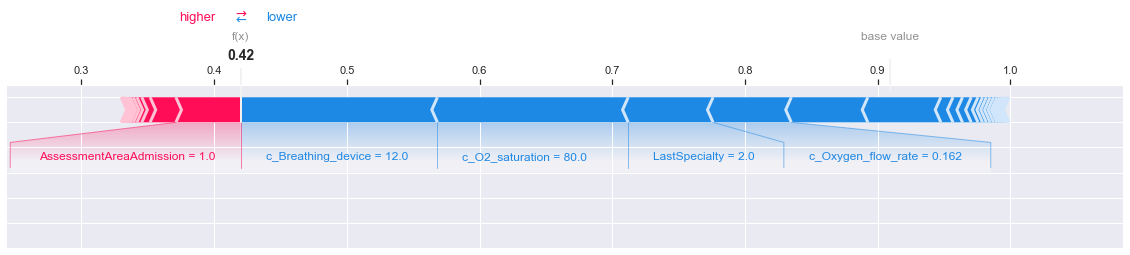

In [374]:
shap.force_plot(explainer.expected_value[0], shap_values[0][9,:], X_test.iloc[9], feature_names=X.columns, matplotlib=True)

## Anomaly Detection

### Isolation Forest

In [458]:
from sklearn.ensemble import IsolationForest

def test_isolation_forest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25
    )
    
    return spotCheckCV(
        {
            'Isolation Forest': IsolationForest(),
            'Isolation Forest (contamination)': IsolationForest(contamination=y_train.sum()/y_train.shape[0])
        }, X_train, y_train.map({True: -1, False: 1})
    )


Imputed blood, one-hot encoded diagnoses

In [313]:
test_isolation_forest(
    *sci.omit_redundant()
    .omit_ae()
    .impute_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", dropna=True)
)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Isolation Forest,9.661430,4.910671,0.915076,0.988740,0.924104,0.792633,0.955294,0.936325
Isolation Forest (contamination),14.585537,4.792838,0.970141,0.984859,0.984746,0.792221,0.984803,0.984769


All mandatory, one-hot encoded diagnoses

In [314]:
test_isolation_forest(
    *sci.omit_redundant()
    .omit_ae()
    .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", dropna=True)
)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Isolation Forest,4.034873,2.356329,0.896721,0.988941,0.905063,0.773860,0.945120,0.920666
Isolation Forest (contamination),6.408749,2.351811,0.969944,0.984885,0.984530,0.789229,0.984707,0.984601


Imputed everything, one-hot encoded diagnoses

In [336]:
test_isolation_forest(
    *sci.omit_redundant()
    .omit_ae()
    .impute_blood()
    .raw_news()
    .impute_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", dropna=True)
)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Isolation Forest,17.180474,8.766413,0.911065,0.988519,0.920278,0.709862,0.953166,0.933154
Isolation Forest (contamination),25.563209,8.626533,0.971207,0.985431,0.985295,0.712184,0.985363,0.985322


Training with missing data

In [466]:
test_isolation_forest(
    *sci.omit_redundant()
    .omit_ae()
    .impute_blood()
    .raw_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", ordinal_encoding=True, fillna=True)
)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Isolation Forest,5.584301,8.201466,0.906270,0.985453,0.918280,0.696361,0.950665,0.930962
Isolation Forest (contamination),14.109466,8.129559,0.968125,0.983714,0.983885,0.701493,0.983799,0.983851


In [463]:
X, y = (
    sci.omit_redundant()
    .omit_ae()
    .impute_blood()
    .raw_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
    .xy(outcome="CriticalEvent", ordinal_encoding=True, fillna=True)
)

The best performance is achieved with all parameters mandatory, i.e. the smallest dataset variant.

In [289]:
scii = (
    sci.omit_redundant()
    .omit_ae()
    .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
)

X, y = scii.xy(outcome="CriticalEvent", ordinal_encoding=True, dropna=True)
contamination = y.sum()/y.shape[0]
y = y.map({True: -1, False: 1})
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

In [297]:
model = IsolationForest(contamination=contamination).fit(X_train)

SHAP finds some clear relationships, such as incidence of certain diagnostic groups, assisted breathing/breathing device, and certain specialties.

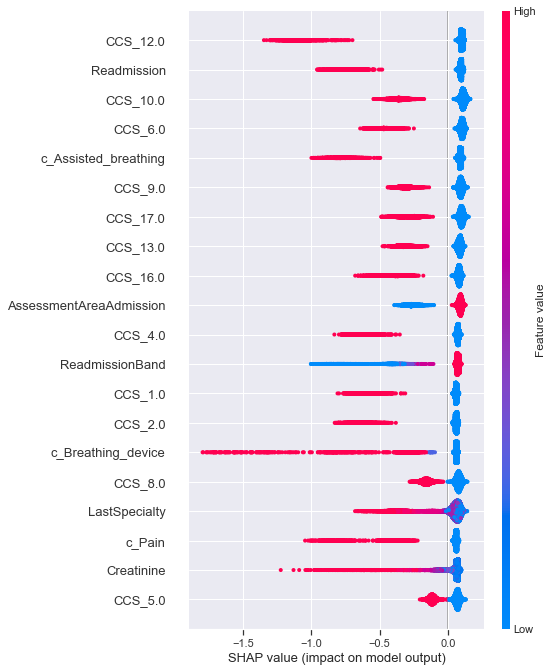

In [298]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

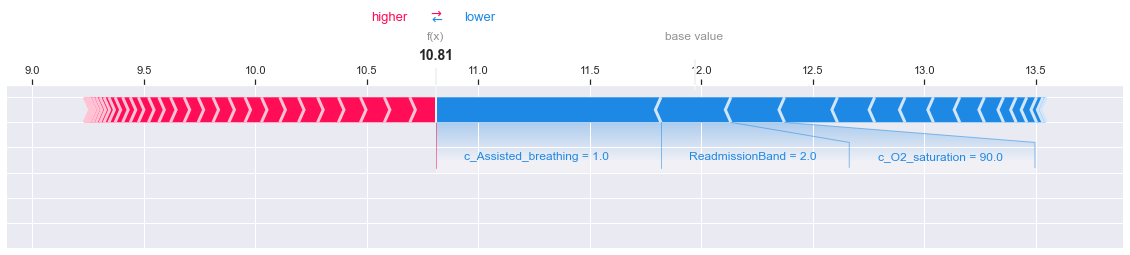

In [231]:
shap.force_plot(explainer.expected_value, shap_values[33,:], X_test.iloc[33], feature_names=X.columns, matplotlib=True)

### One-Class SVM (SGD)

These are "known to be sensitive to outliers and thus does not perform very well for outlier detection". [[Source]](https://datascience.stackexchange.com/a/69449)

By training on some of the "outliers" we teach the model that they are "normal" points. So, we train on a subset that contains *only* negative instances. The positive instances are only present in the test set.

In [155]:
scii = (
    sci.omit_redundant()
    .omit_ae()
    .impute_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
)

X, y = scii.xy(outcome="CriticalEvent", x=SCICols.news_data_raw, dropna=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)
X_train, y_train = X_train[~y_train], y_train[~y_train]

In [158]:
from sklearn.linear_model import SGDOneClassSVM

model = SGDOneClassSVM().fit(X_train)
get_metrics(y_true=y_test.map({True: -1, False:1}), y_pred=model.predict(X_test))

{'Accuracy': 0.5063390460458393,
 'Precision': 0.9887705391792585,
 'Recall': 0.5032992897070567,
 'F1 Score': 0.667056595365419,
 'F2 Score': 0.5581033341722361}

In [162]:
print(f'AUC: {roc_auc_score(y_true=y_test.map({True:-1, False:1}), y_score=model.decision_function(X_test))}')

AUC: 0.6284679292547511


### KNN

In [32]:
scii = (
    sci.omit_redundant()
    .omit_ae()
   # .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
)

X, y = scii.xy(outcome="CriticalEvent", ordinal_encoding=True, dropna=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

In [14]:
from pyod.models.knn import KNN

In [24]:
spotCheckCV(KNN(contamination=y_train.sum()/y_train.shape[0]), X_train, y_train)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Model,23.799574,61.932594,0.971329,0.186653,0.190039,0.836224,0.187151,0.188607


In [26]:
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest

# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
# then clf can be used as any outlier detection model
clf = SUOD(base_estimators=detector_list, n_jobs=-1, combination='average',
           verbose=False, contamination=y_train.sum()/y_train.shape[0])

In [33]:
spotCheckCV(clf, X_train, y_train)

,fit_time,score_time,test_Accuracy,test_Precision,test_Recall,test_AUC,test_F1 Score,test_F2 Score
model,,,,,,,,
Model,301.366398,7.575052,0.979197,0.214556,0.091745,0.817292,0.128334,0.103541


## TabNet

In [96]:
scii = (
    sci.omit_redundant()
    .drop(["ReadmissionBand", "AgeBand", "AdmissionSpecialty"], axis=1)
    .omit_ae()
    .mandate_blood()
    .raw_news()
    .mandate_news()
    .augment_hsmr()
    .encode_ccs_onehot()
    .mandate_diagnoses()
)
X, y = scii.xy(outcome="CriticalEvent", ordinal_encoding=False, dropna=True)

categorical_cols_idx, categorical_dims = X.describe_categories()

X = X.ordinal_encode_categories()

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25
)

In [137]:
import torch 
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_params = dict(
    n_a = 4,
    n_d = 4,
    cat_idxs = categorical_cols_idx,
    cat_dims = categorical_dims,
    cat_emb_dim = 1,
    optimizer_fn = torch.optim.Adam,
    optimizer_params = dict(
        lr = 2e-2
    ),
    scheduler_params = dict(
        step_size = 50,
        gamma = 0.9
    ),
    scheduler_fn = torch.optim.lr_scheduler.StepLR,
    mask_type = 'entmax'
)
model = TabNetClassifier(**tabnet_params
                      )

Device used : cpu


In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.33
)

In [123]:
from pytorch_tabnet.metrics import Metric

class F2TabNet(Metric):
    def __init__(self):
        self._name = "F2"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)
        return fbeta_score(y_true, y_pred, beta=2)

In [138]:
model.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'valid'],
    eval_metric = [F2TabNet, 'auc'],
    max_epochs = 300, patience=50,
    batch_size = 512, virtual_batch_size = 128,
    num_workers = 0,
    weights = 1,
    drop_last = False,
    #augmentations = None
)

epoch 0  | loss: 0.63191 | train_F2: 0.13867 | train_auc: 0.72289 | valid_F2: 0.14992 | valid_auc: 0.70112 |  0:00:02s
epoch 1  | loss: 0.5199  | train_F2: 0.10882 | train_auc: 0.63452 | valid_F2: 0.1264  | valid_auc: 0.62334 |  0:00:04s
epoch 2  | loss: 0.43157 | train_F2: 0.08516 | train_auc: 0.66797 | valid_F2: 0.0938  | valid_auc: 0.64935 |  0:00:07s
epoch 3  | loss: 0.35422 | train_F2: 0.1652  | train_auc: 0.77743 | valid_F2: 0.17535 | valid_auc: 0.76047 |  0:00:09s
epoch 4  | loss: 0.32195 | train_F2: 0.25093 | train_auc: 0.85552 | valid_F2: 0.25039 | valid_auc: 0.83038 |  0:00:11s
epoch 5  | loss: 0.27637 | train_F2: 0.23264 | train_auc: 0.87869 | valid_F2: 0.24005 | valid_auc: 0.81878 |  0:00:13s
epoch 6  | loss: 0.25472 | train_F2: 0.38494 | train_auc: 0.94058 | valid_F2: 0.33777 | valid_auc: 0.86524 |  0:00:16s
epoch 7  | loss: 0.21653 | train_F2: 0.44971 | train_auc: 0.96172 | valid_F2: 0.37801 | valid_auc: 0.88603 |  0:00:18s
epoch 8  | loss: 0.20185 | train_F2: 0.51611 | t

<AxesSubplot:>

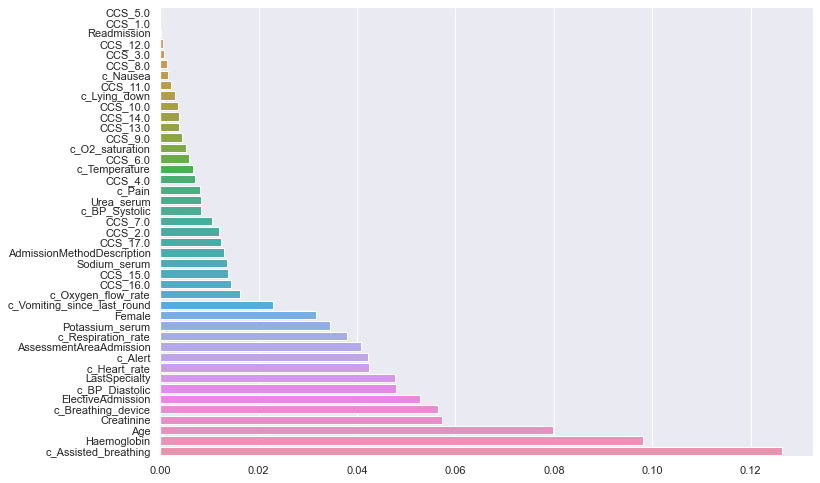

In [139]:
sorted_idx = model.feature_importances_.argsort()
sns.barplot(x=model.feature_importances_[sorted_idx], y=X.columns[sorted_idx])


In [171]:
explain_matrix, masks = model.explain(X_test[6:7])
list(sorted(zip(X.columns, explain_matrix[0]), key=lambda x: x[1]))

[('AdmissionMethodDescription', 0.0),
 ('c_Oxygen_flow_rate', 0.0),
 ('c_Lying_down', 0.0),
 ('c_BP_Systolic', 0.0),
 ('c_Pain', 0.0),
 ('c_Vomiting_since_last_round', 0.0),
 ('Readmission', 0.0),
 ('CCS_1.0', 0.0),
 ('CCS_3.0', 0.0),
 ('CCS_5.0', 0.0),
 ('CCS_6.0', 0.0),
 ('CCS_7.0', 0.0),
 ('CCS_11.0', 0.0),
 ('CCS_12.0', 0.0),
 ('CCS_15.0', 0.0),
 ('CCS_17.0', 0.0),
 ('CCS_8.0', 0.0005393879837356508),
 ('c_Temperature', 0.000987207517027855),
 ('CCS_13.0', 0.0035212072543799877),
 ('CCS_14.0', 0.0037878842558711767),
 ('CCS_4.0', 0.004061009269207716),
 ('CCS_9.0', 0.007504897657781839),
 ('CCS_10.0', 0.0147214001044631),
 ('c_Respiration_rate', 0.01520739495754242),
 ('Creatinine', 0.020798563957214355),
 ('CCS_2.0', 0.023305442184209824),
 ('c_O2_saturation', 0.023730099201202393),
 ('Urea_serum', 0.02489355579018593),
 ('c_Nausea', 0.025547925382852554),
 ('AssessmentAreaAdmission', 0.05077813193202019),
 ('c_Heart_rate', 0.057590752840042114),
 ('c_Alert', 0.13102586567401886),